In [ ]:
# Copyright 2024 Tsinghua University and ByteDance.
#
# Licensed under the MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://opensource.org/license/mit
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# Config
# Use q8 quantization with BitsAndBytes
USE_Q8_QUANTIZATION = False

In [ ]:
"""
    A very simple demo to load ChatTS model and use it.
"""
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer, AutoProcessor
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

if USE_Q8_QUANTIZATION:
    from transformers import BitsAndBytesConfig 

from chatts.encoding_utils import eval_prompt_to_encoding

In [4]:
# Set Environment and Load model
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
if USE_Q8_QUANTIZATION:
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    model = AutoModelForCausalLM.from_pretrained("./ckpt", trust_remote_code=True, device_map='cuda:0', quantization_config=quantization_config, torch_dtype="auto")
else:
    model = AutoModelForCausalLM.from_pretrained("./ckpt", trust_remote_code=True, device_map='cuda:0', torch_dtype='float16')
tokenizer = AutoTokenizer.from_pretrained("./ckpt", trust_remote_code=True)
processor = AutoProcessor.from_pretrained("./ckpt", trust_remote_code=True, tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

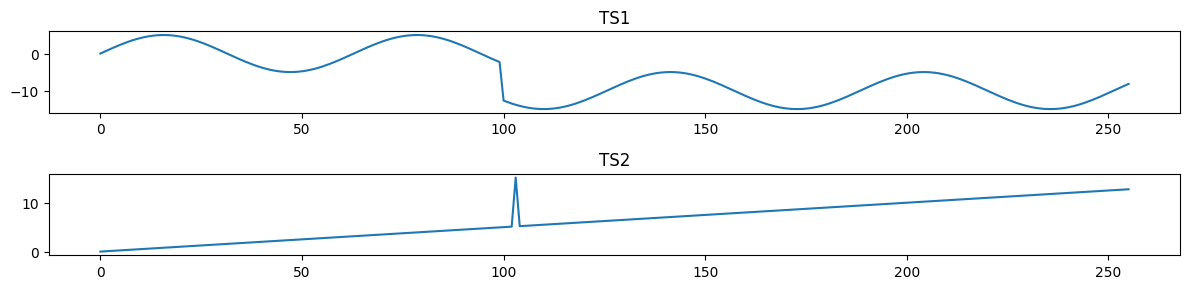

In [2]:
# Generate a time series example
SEQ_LEN = 256
x = np.arange(SEQ_LEN)
# TS1: A simple sin signal with a sudden decrease
ts1 = np.sin(x / 10) * 5.0
ts1[100:] -= 10.0
# TS2: A increasing trend with a upward spike
ts2 = x * 0.05
ts2[103] += 10.0

# Plot TS1 and TS2
plt.figure(figsize=(12, 3))
plt.subplot(211)
plt.plot(ts1)
plt.title('TS1')
plt.subplot(212)
plt.plot(ts2)
plt.title('TS2')
plt.tight_layout()

In [ ]:
# Convert time series to encoding
prompt = f"I have 2 time series. TS1 is of length {SEQ_LEN}: <ts><ts/>; TS2 if of length {SEQ_LEN}: <ts><ts/>. Please analyze the local changes in these time series first and then conclude if these time series showing local changes near the same time?"

# Apply Chat Template
prompt = f"<|im_start|>system\nYou are a helpful assistant.<|im_end|><|im_start|>user\n{prompt}<|im_end|><|im_start|>assistant\n"

# Convert to tensor
inputs = processor(text=[prompt], timeseries=[ts1, ts2], padding=True, return_tensors="pt")
streamer = TextStreamer(tokenizer)

# Input into model
print('Generating...')
outputs = model.generate(
                **inputs,
                max_new_tokens=300,
                streamer=streamer
            )

# Show output
input_len = inputs['attention_mask'][0].sum().item()
output = outputs[0][input_len:]
text_out = tokenizer.decode(output, skip_special_tokens=True)
print('--------> Generated Answer')
print(text_out)

Generating...


--------> Generated Answer
Yes, there is a correlated local fluctuations between them. An upward spike with an amplitude of 9.88 occurred between point 104 and point 107 in TS2, while a sudden decrease with an amplitude of 12.35 occurred between point 98 and point 103 in TS1, indicating a possible correlation in terms of local fluctuations.
